**Import packages:**

In [647]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import pandas

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# To print nicely:
sm.init_printing(use_unicode=True)

# 1. Human capital accumulation

**We define the variables used in the analysis:**

w: wage rate <br>
b: unemployment benefit <br>
$c_t$: consumption in period t <br>
$h_t$: human capital in period t <br>
$l_t$: labor supply in period t <br>
$\rho$: risk aversion coefficient <br>
$\gamma$: degree of disutility from working <br>
$\Delta$: stochastic experience gain <br>
$\beta$: discount factor

**Defining the necessary equations and the values of l.**

In [135]:
l = [0, 1]

def consumption(w,h,b,l):
    """
    If the person doesn't work (l = 0), she will recieve an unemployment benefit (b) instead of a wage income.
    If the person works (l = 1), she will receive a wage income based on the wage (w) and her human capital (h).
    """
    if l == 0:
        c = b
    elif l == 1:
        c = w*h
    return c

def utility(rho,h,w,b,l):
    return consumption(w,h,b,l)**(1-rho)/(1-rho)

def disutility(l,gamma):
    return gamma*l

def v2(l2,h2,w,b,rho,gamma):
    return utility(rho,h2,w,b,l2) - disutility(l2,gamma)

**Setting parameter values:**

In [84]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [136]:
def solve_period_2(w,b,rho,gamma):
    """
    The function solves the utility maximizing problem in period 2 for different values of human capital in period 2.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """
    # a. grids
    h2_vec = np.linspace(0.1,1.5,100)
    l2_vec = np.empty(100)
    c2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h2 in enumerate(h2_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v2_0 = v2(l[0],h2,w,b,rho,gamma)
        v2_1 = v2(l[1],h2,w,b,rho,gamma)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v2_vec[i] = max(v2_0,v2_1)
        l2_vec[i] = v2_1 > v2_0
        c2_vec[i] = consumption(w,h2,b,l2_vec[i])
        
    return h2_vec,v2_vec,l2_vec,c2_vec

In [155]:
# solving for period 2 and assigning values to different vectors.
h2_vec,v2_vec,l2_vec,c2_vec = solve_period_2(w,b,rho,gamma);

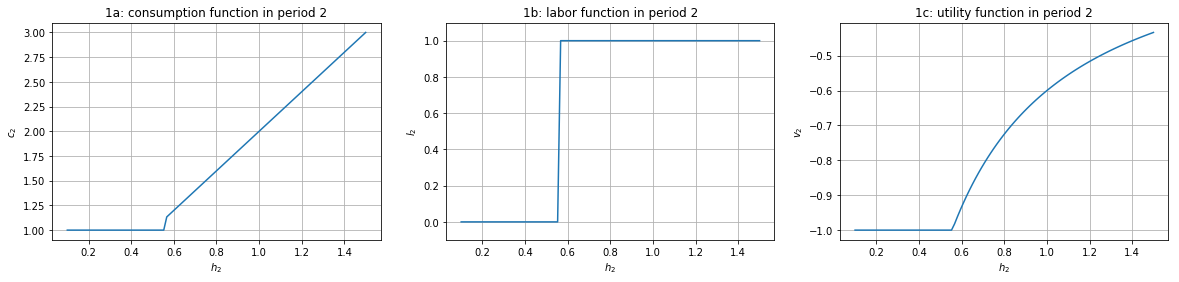

In [157]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the utility maximizing problem in period 2.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h2_vec,c2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$c_2$')
ax.set_title('1a: consumption function in period 2')

ax = fig.add_subplot(1,3,2)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$l_2$')
ax.set_title('1b: labor function in period 2')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h2_vec,v2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$v_2$')
ax.set_title('1c: utility function in period 2');

**Identifying the level of human capital necessary for the individual to work:**

In [177]:
index = np.where(l2_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h2_vec[index],3)))

She chooses to work when h ≥ 0.567


**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

**Construct interpolator:**

In [80]:
# Defining an interpolating function based on data from figure 1c.
v2_interp = interpolate.RegularGridInterpolator([h2_vec], v2_vec, bounds_error=False,fill_value=None)

***Defining $v_1$:*** <br>
We use the interpolated function to define the expected utility in period 2, accounting for two possible scenarios, <br> one scenario with a stochastic experience gain to the human capital in period 2 and one without.

In [81]:
def v1(l1,h1,w,b,rho,gamma,beta,Delta,v2_interp):
    
    # a. v2 value without a stochastic experience gain
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # b. v2 value with a stochastic experience gain
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected value of v2
    v2 = 0.5 * v2_low + 0.5 * v2_high
    
    # d. total value
    return utility(rho,h1,w,b,l1) - disutility(l1,gamma) + beta*v2

In [85]:
def solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp):
    """
    The function solves the intertemporal utility maximizing problem in period 1,
    for different values of human capital in period 1 considering both periods.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """ 
    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    l1_vec = np.empty(100)
    c1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v1_0 = v1(l[0],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        v1_1 = v1(l[1],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v1_vec[i] = max(v1_0,v1_1)
        l1_vec[i] = v1_1 > v1_0
        c1_vec[i] = consumption(w,h1,b,l1_vec[i])
        
    return h1_vec,v1_vec,l1_vec,c1_vec

In [159]:
# solving for period 1 and assigning values to different vectors.
h1_vec,v1_vec,l1_vec,c1_vec = solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp)

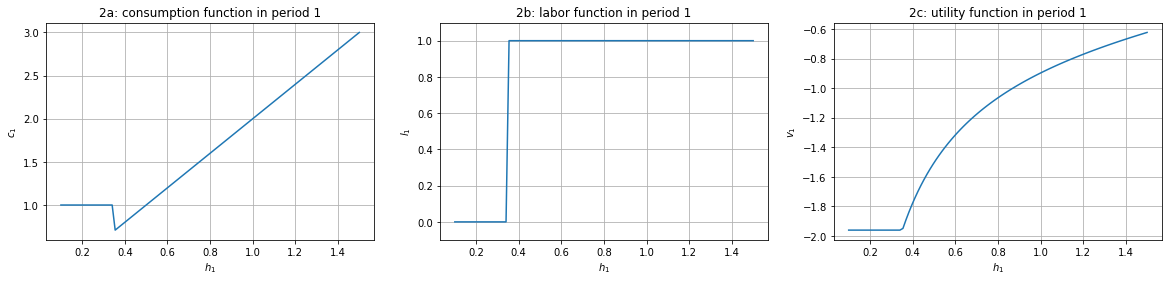

In [160]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the intertemporal utility maximizing problem in period 1.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h1_vec,c1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$c_1$')
ax.set_title('2a: consumption function in period 1')

ax = fig.add_subplot(1,3,2)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$l_1$')
ax.set_title('2b: labor function in period 1')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h1_vec,v1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$v_1$')
ax.set_title('2c: utility function in period 1');

**Identifying the level of human capital necessary for the individual to work:**

In [178]:
index = np.where(l1_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h1_vec[index],3)))

She chooses to work when h ≥ 0.355


**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

As can be seen in figure 2a the worker will choose to work even though her potential wage income is lower than the unemployment benefit, i.e. her consumption is lower when she chooses to work.
The reason for this, is that she improves her human capital in period 2 by working in period 1. This will then improve her consumption more in period 2 than it reduces her consumption in period 1.

# 2. AS-AD model

**Defining symbols:**

In [577]:
pi = sm.symbols("pi_t")
y = sm.symbols("y_t")
pi_e = sm.symbols("pi^e_t")
s = sm.symbols("s_t")
v = sm.symbols("v_t")
pi1 = sm.symbols("pi_t-1")
y1 = sm.symbols("y_t-1")
s1 = sm.symbols("s_t-1")
pistar = sm.symbols("pi^*")
ystar = sm.symbols("y^*")
alpha = sm.symbols("alpha")
gamma = sm.symbols("gamma")
phi = sm.symbols("phi")
h = sm.symbols("h")
b = sm.symbols("b")

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Defining our AD-curve:**

In [578]:
AD = sm.Eq(pi,(v - (1 + b*alpha)*y)/(h*alpha))
AD

**Defining our SRAS-curve:**

In [579]:
SRAS = sm.Eq(pi,pi1 + gamma*y - phi*gamma*y1 + s - phi*s1)
SRAS

Finding equilibrium values for output gap, $y_t$, and inflation gap, $\pi_t$.

In [580]:
# Solving
Eq = sm.solve([AD, SRAS], [y, pi])
pi_eq = Eq[pi]
y_eq = Eq[y]

# Creating functions of pi and y for later use
pi_func = sm.lambdify((pi1, y1, v, s, s1, alpha, h, b, phi, gamma), pi_eq)
y_func = sm.lambdify((pi1, y1, v, s, s1, alpha, h, b, phi, gamma), y_eq)

**Output gap:**

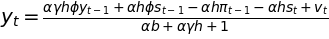

In [581]:
sm.Eq(y,y_eq)

**Inflation gap:**

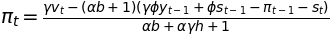

In [582]:
sm.Eq(pi,pi_eq)

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Setting the parameters of the model:**

In [583]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Assigning values to variables:**

In [584]:
y1 = 0
pi1 = 0
s = 0
s1 = 0
v_vec = [0,0.1]

In [585]:
pi_vec = []
y_vec = []

for val in v_vec:
    pi_vec.append(pi_func(0, 0, val, 0, 0, par['alpha'], par['h'], par['b'], par['phi'], par['gamma']))
    y_vec.append(y_func(0, 0, val, 0, 0, par['alpha'], par['h'], par['b'], par['phi'], par['gamma']))

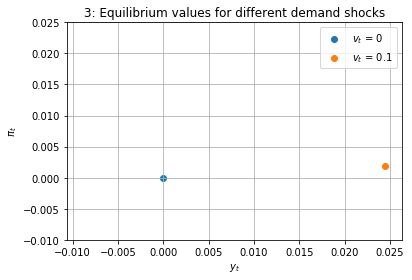

In [586]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(y_vec[0], pi_vec[0], label='$v_t$ = 0')
ax.scatter(y_vec[1], pi_vec[1], label='$v_t$ = 0.1')
ax.grid()
ax.legend()
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.set_ylim([-0.010,0.025])
ax.set_title('3: Equilibrium values for different demand shocks');

In [587]:
headers = ["$v_t = 0$", "$v_t = 0.1$"]
rows = ["$\pi_t$", "$y_t$"]
data = np.array([[pi_vec[0],pi_vec[1]],[y_vec[0],y_vec[1]]])
pandas.DataFrame(data,rows,headers)

,$v_t = 0$,$v_t = 0.1$
$\pi_t$,0.0,0.001831
$y_t$,0.0,0.024414


We can see that a positive demand shock increases both inflation gap and output gap but the output gap increases the most.

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Defining functions for demand and supply shocks:**

In [588]:
v_func = lambda v1,x: delta*v1 + x
s_func = lambda s1,c: omega*s1 + c

**Setting new parameter values:**

In [589]:
delta = par['delta'] = 0.80
omega = par['omega'] = 0.15

**Creating empty vectors for initial values:**

In [590]:
pi_vec_q3 = [0]
y_vec_q3 = [0]
v_vec = [0]
s_vec = [0]

**Choosing the period length and defining x and c for each period:**

In [591]:
T = 7
c = np.zeros(T)
x = np.zeros(T)

# setting x0 value
x[1] = 0.1

**Running the simulation and appending values to vectors:**

In [592]:
output = pandas.DataFrame(index=np.arange(0,T-1),columns=('t','$\pi_t$', '$y_t$'))

for t in range(1,T):
    
    # i. update v and s
    v_vec.append(v_func(v_vec[t-1], x[t]))
    s_vec.append(s_func(s_vec[t-1], c[t]))
    
    # ii. compute y og pi
    y_vec_q3.append(y_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], par['phi'], par['gamma']))
    pi_vec_q3.append(pi_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], par['phi'], par['gamma']))
    
    output.iloc[t-1] = [t-2, round(pi_vec_q3[t-1],4), round(y_vec_q3[t-1],4)]
    
blankIndex=[''] * len(output)
output.index=blankIndex
output

,t,$\pi_t$,$y_t$
,-1,0,0
,0,0.0018,0.0244
,1,0.0032,0.0182
,2,0.0042,0.0134
,3,0.0049,0.0095
,4,0.0054,0.0065


**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**The standard deviation of the shocks are:**

In [593]:
sigma_x = par['sigma_x'] = 3.492
sigma_c = par['sigma_c'] = 0.2

**Defining stochastic process:**

In [607]:
# number of periods
T = 1000

# seed number
np.random.seed(2019)

# creating x and c vectors
x = np.random.normal(0,sigma_x,T)
c = np.random.normal(0,sigma_c,T)

def simulation(T,phi_custom):

    # creating pi, y, v and s vectors with initial values
    pi_vec_q4 = [0]
    y_vec_q4 = [0]
    v_vec = [0]
    s_vec = [0]

    for t in range(1,T):
    
        # i. update v and s
        v_vec.append(v_func(v_vec[t-1], x[t]))
        s_vec.append(s_func(s_vec[t-1], c[t]))
    
        # ii. compute y and pi
        y_vec_q4.append(y_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], phi_custom, par['gamma']))
        pi_vec_q4.append(pi_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], phi_custom, par['gamma']))
    
    # convert lists to numpy arrays
    pi_vec_q4 = np.array(pi_vec_q4)
    y_vec_q4 = np.array(y_vec_q4)
    
    # saving the correlation coefficient
    correlation = np.corrcoef(y_vec_q4, pi_vec_q4)[1,0]
    
    return y_vec_q4, pi_vec_q4, correlation

y_vec_q4, pi_vec_q4, correlation = simulation(T, par['phi'])

# calculate statistics
stats_q4 = []
stats_q4.append(y_vec_q4.var())
stats_q4.append(pi_vec_q4.var())
stats_q4.append(np.corrcoef(y_vec_q4, pi_vec_q4)[1,0])
stats_q4.append(np.corrcoef(y_vec_q4[1:], y_vec_q4[:-1])[1,0])
stats_q4.append(np.corrcoef(pi_vec_q4[1:], pi_vec_q4[:-1])[1,0])

In [608]:
row_q4 = ['Var($y_t$)', 'Var($\pi_t$)', 'corr($y_t,\pi_t$)', 'corr($y_t,y_t-1$)','corr($\pi_t,\pi_t-1$)']
stats = pandas.DataFrame(stats_q4,row_q4)

In [609]:
stats

,0
Var($y_t$),1.960337
Var($\pi_t$),0.964009
"corr($y_t,\pi_t$)",-0.163420
"corr($y_t,y_t-1$)",0.767174
"corr($\pi_t,\pi_t-1$)",0.976682


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Creating a vector containing different values of $\phi$:**

In [610]:
phi_q5 = np.linspace(0,1,50)

**Running the simulation for the different values of $\phi$:**

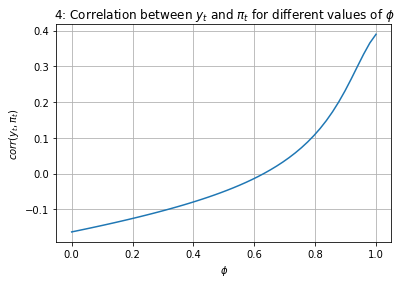

In [611]:
# creating a list containing the correlation coefficients
corr = []

for p in phi_q5:
    y_vec_q4, pi_vec_q4, correlation = simulation(T, p)
    corr.append(correlation)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(phi_q5,corr)
ax.grid()
ax.set_xlabel('$\phi$')
ax.set_ylabel('$corr(y_t,\pi_t)$')
ax.set_title('4: Correlation between $y_t$ and $\pi_t$ for different values of $\phi$');

**Defining the objective function that we want to minimize:**

In [612]:
# The function defines the difference between the simulated correlation coefficient and the desired coefficient
obj = lambda phi: simulation(T,phi)[2] - 0.31

**Using a root finder to identify the value of $\phi$ that minimizes the objective function:**

In [666]:
# run root finder and save the phi value
phi_opt = optimize.root(obj, x0 = 0.9)
phi_opt = phi_opt.x

# print results
print('The value of phi that generates the desired correlation coefficient is: ' + str(round(phi_opt[0],2)))
print('Check for correct correlation coefficient. Corr: ' + str(round(simulation(T,phi_opt)[2],2)))

The value of phi that generates the desired correlation coefficient is: 0.94
Check for correct correlation coefficient. Corr: 0.31
